# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [375]:
# # Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [376]:
from load_data import load_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
import seaborn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats
import numpy as np
import statistics

# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn import metrics

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

features = data.drop(columns=['label'])
label = data.label

# Splitting data in train and test group
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.2)
#print(features)

y_train_bin = []
for val in y_train:
  if val == 'T12':
    y_train_bin.append(0)
  else:
    y_train_bin.append(1) 


The number of samples: 113
The number of columns: 160


## Preprocessing

### Scaling

In [377]:
# Scale the dataset
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = features.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = features.columns)

### Removing outliers



In [378]:
# Create the dataframe
outlier_feat = []
for feature in X_train_scaled.columns:
    # IQR
    Q1 = np.percentile(X_train_scaled[feature], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(X_train_scaled[feature], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
 
    # Upper bound
    X_train_scaled.loc[X_train_scaled[feature] >= (Q3+1.5*IQR),feature] = statistics.median(X_train_scaled[feature])

    # Lower bound
    X_train_scaled.loc[X_train_scaled[feature] <= (Q3-1.5*IQR),feature] = statistics.median(X_train_scaled[feature])


for feature in X_test_scaled.columns:
    # IQR
    Q1 = np.percentile(X_test_scaled[feature], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(X_test_scaled[feature], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
 
    # Upper bound
    X_test_scaled.loc[X_test_scaled[feature] >= (Q3+1.5*IQR),feature] = statistics.median(X_test_scaled[feature])
    # Lower bound
    X_test_scaled.loc[X_test_scaled[feature] <= (Q3-1.5*IQR),feature] = statistics.median(X_test_scaled[feature])


## Feature selection

### T-test

In [379]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns) # make df from numpy
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_train.columns)
X_train_scaled_df['Label'] = y_train_bin
X_train_T12 = X_train_scaled_df.groupby('Label').get_group(0)
X_train_T34 = X_train_scaled_df.groupby('Label').get_group(1)
X_train_T12 = X_train_T12.drop(columns = ['Label'])
X_train_T34 = X_train_T34.drop(columns = ['Label'])

# ttest
_,pval = stats.ttest_ind(X_train_T12,X_train_T34)


sig_feat = []
for id, val in enumerate(pval):
  if val < 0.05/X_train_scaled_df.shape[1]:
    sig_feat.append(list(X_train.columns)[id])
print(f'Number of significant different features: {len(sig_feat)}')

X_train_sig = X_train_scaled_df[sig_feat]
X_test_sig = X_test_scaled_df[sig_feat]
# #Pairplot of sign features
# X_train_sig.columns =['Feature'+ str(pc) for pc in range(1,len(sig_feat)+1)]
# X_train_sig['Label'] = y_train_bin
# pair_plot = seaborn.pairplot(X_train_sig, hue = 'Label')

Number of significant different features: 19


## PCA

In [350]:
# N_COMP = 10
# pca = PCA(n_components=N_COMP)
# pca.fit(X_train_sig)
# X_train_pca = pca.transform(X_train_sig)
# X_test_pca = pca.transform(X_test_sig)


# seaborn.scatterplot(x=X_train_pca[:,0],y=X_train_pca[:,1],hue=y_train)
# scatter_data = pd.DataFrame(X_train_pca[:,:], columns = ['Principal component' + str(pc) for pc in range(1,N_COMP+1)])
# scatter_data['Stage'] = y_train_bin
# seaborn.pairplot(scatter_data, hue = 'Stage')
# print(scatter_data)

# Classifier

## Testing variety of classifiers

In [351]:
# Construct classifiers
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

clsfs = [KNeighborsClassifier(), RandomForestClassifier(),QuadraticDiscriminantAnalysis(),GaussianNB(),LinearDiscriminantAnalysis(),svmlin, svmpoly, svmrbf]

for clf in clsfs:
    # Fit classifier
    clf.fit(X_train_sig,y_train)
    y_pred_train=clf.predict(X_train_sig)
    print(clf)
    acc_train = (y_train==y_pred_train).sum()/len(X_train_sig)
    print(f'Train data acc: {acc_train}')
    y_pred_test = clf.predict(X_test_sig)
    acc_test = (y_test==y_pred_test).sum()/len(X_test_sig)
    print(f'Test data acc: {acc_test}')


KNeighborsClassifier()
Train data acc: 0.8111111111111111
Test data acc: 0.6086956521739131
RandomForestClassifier()
Train data acc: 1.0
Test data acc: 0.6521739130434783
QuadraticDiscriminantAnalysis()
Train data acc: 0.8222222222222222
Test data acc: 0.7391304347826086
GaussianNB()
Train data acc: 0.7444444444444445
Test data acc: 0.8260869565217391
LinearDiscriminantAnalysis()
Train data acc: 0.7666666666666667
Test data acc: 0.5652173913043478
SVC(kernel='linear')
Train data acc: 0.7777777777777778
Test data acc: 0.6086956521739131
SVC(kernel='poly')
Train data acc: 0.7666666666666667
Test data acc: 0.6521739130434783
SVC()
Train data acc: 0.8222222222222222
Test data acc: 0.6521739130434783


## Optimizing KNN

In [352]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
X_train_sig_a = X_train_sig.to_numpy()
y_train_a = y_train.to_numpy()

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_sig_a,y_train_a):
    # Split the data properly
    X_validation = X_train_sig_a[validation_index]
    y_validation = y_train_a[validation_index]
    
    X_test_op = X_train_sig_a[test_index]
    y_test_op = y_train_a[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 31, 2))}
    knn = KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test_op)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test_op, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
# seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")
# print(results)


# Use the optimal parameters without any tuning to validate the optimal classifier
clf = KNeighborsClassifier(n_neighbors=optimal_n)

# Fit on the entire dataset
clf.fit(X_train_sig, y_train)

# Test the classifier on the indepedent replication data
probabilities = clf.predict_proba(X_test_sig)
scores = probabilities[:, 1]

# Get the auc
auc = metrics.roc_auc_score(y_test, scores)
print(f'THe AUC on the replication set is {auc} using a {clf.n_neighbors}-NN classifier')


knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train_sig, y_train)
score_train_kNN = knn.score(X_train_sig, y_train)
score_test_kNN = knn.score(X_test_sig, y_test)
print(f"Training result kNN: {score_train_kNN}")
print(f"Test result kNN: {score_test_kNN}")

Best classifier: k=25
Best classifier: k=25
Best classifier: k=27
Best classifier: k=5
Best classifier: k=13
The optimal N=25
THe AUC on the replication set is 0.8412698412698412 using a 25-NN classifier
Training result kNN: 0.6777777777777778
Test result kNN: 0.6956521739130435


In [353]:
print(y_test.shape)
print(X_test_sig.shape)

(23,)
(23, 14)


## Optimizing Random forest

Best classifier: n=12
Best classifier: n=4
Best classifier: n=10
Best classifier: n=11
Best classifier: n=25
The optimal N=11
        auc   n         set
0  0.675000  12        test
1  0.966049  12  validation
2  0.635802   4        test
3  0.918147   4  validation
4  0.839506  10        test
5  0.969112  10  validation
6  0.753086  11        test
7  0.942857  11  validation
8  0.567901  25        test
9  0.953668  25  validation


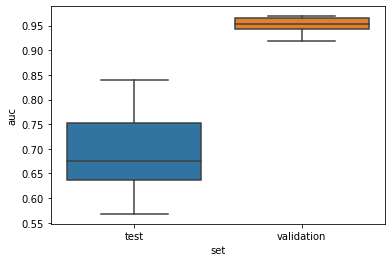

In [354]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
X_train_sig_a = X_train_sig.to_numpy()
y_train_a = y_train.to_numpy()

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_sig_a,y_train_a):
    # Split the data properly
    X_validation = X_train_sig_a[validation_index]
    y_validation = y_train_a[validation_index]
    
    X_test = X_train_sig_a[test_index]
    y_test = y_train_a[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_estimators": list(range(1, 50))}
    rf = RandomForestClassifier(criterion= "gini", bootstrap = True, min_samples_leaf = 5)
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(rf, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: n={clf.n_estimators}')
    best_n_neighbors.append(clf.n_estimators)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'n': clf.n_estimators,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'n': clf.n_estimators,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")
print(results)